# Predição de Dengue - Modelos de Classificaao KNN e SVM
## Autor - Francisco Flávio Cardoso Gomes
## Fonte de dados 
### Dados Metereológicos - Inmet - Instituto Nacional de Metereologia
### Dados de Infectados por dengue - SinanWeb - Sistema de Notificação de Agravos e Notificação


### Este modelo avalia os modelos de KNN(k-Nearest Neighbors e SVM(Support vector machine) para previsão de picos de casos de Dengue em Fortaleza

## - Periodicidade da Série Temporal - Semanal

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import  pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')
import time as time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


### Lê Dados Metereológicos

In [2]:
file='./Dados/Fortaleza/Fortaleza_Inmet_Diario_Corrigido.csv'
data = pd.read_csv(file,sep=',')
data = data.rename(columns={'Evaporacao Piche': 'Evaporacao', 'Temp Comp Media': 'TempMedia','Umidade Relativa Media':'Umidade','Velocidade do Vento Media':'VelVento'})
data


,Estacao,Data,Hora,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento,Semana,Ano
0,82397,01/01/2007,0,0.0,30.600000,27.4,8.300000,7.300000,28.000000,74.00000,3.971840,1,2007
1,82397,02/01/2007,0,0.0,32.000000,27.1,11.300000,6.900000,28.820000,69.50000,3.966667,1,2007
2,82397,03/01/2007,0,0.5,29.500000,25.9,1.300000,8.200000,27.240000,81.75000,2.433333,1,2007
3,82397,04/01/2007,0,7.9,31.300000,25.9,11.200000,3.100000,27.800000,71.50000,3.166667,1,2007
4,82397,05/01/2007,0,2.7,28.700000,24.0,3.000000,5.900000,26.520000,83.75000,3.766667,1,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4921,82397,22/06/2019,1200,0.0,31.362319,23.3,7.713613,4.242638,27.176183,77.73468,2.808384,25,2019
4922,82397,23/06/2019,1200,0.0,31.362319,23.3,7.713613,4.242638,27.176183,77.73468,2.808384,25,2019
4923,82397,24/06/2019,0,0.0,30.500000,23.7,8.900000,4.242638,26.480000,77.00000,1.286100,26,2019
4924,82397,25/06/2019,0,0.0,30.600000,23.3,8.800000,4.242638,26.540000,80.00000,2.057760,26,2019


### Lê dados de Infectados por Dengue

In [3]:
file2='./Dados/Fortaleza/Fortaleza_Infectados_Diarios.csv'
data2 = pd.read_csv(file2,sep=',')
data2 = data2.rename(columns={'Data_Notificacao':'Data','Infectados_Dengue':'Infectados'})
data2


,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Verificar dados faltando de Metereologia

In [4]:
tot_nulos=data.isnull().sum()
tot_nulos

Estacao         0
Data            0
Hora            0
Precipitacao    0
TempMaxima      0
TempMinima      0
Insolacao       0
Evaporacao      0
TempMedia       0
Umidade         0
VelVento        0
Semana          0
Ano             0
dtype: int64

### Transforma dados Metereológicos de Diário para Semanal

In [5]:
dataSemana = data.groupby(by=['Ano','Semana'], as_index=False)['Precipitacao','TempMaxima','TempMinima','Insolacao','Evaporacao','TempMedia',	'Umidade',	'VelVento'].sum()


In [6]:
dataSemana

,Ano,Semana,Precipitacao,TempMaxima,TempMinima,Insolacao,Evaporacao,TempMedia,Umidade,VelVento
0,2007,1,17.9,183.6,155.2,45.5,35.000000,166.320000,454.25,21.605174
1,2007,2,18.2,220.9,177.7,58.6,40.100000,195.440000,541.25,23.466666
2,2007,3,1.2,226.1,184.9,59.3,39.200000,199.820000,520.75,24.966668
3,2007,4,0.0,225.2,183.9,62.2,45.600000,199.860000,511.50,23.214440
4,2007,5,9.7,223.8,184.6,43.4,38.600000,198.180000,543.25,20.033333
...,...,...,...,...,...,...,...,...,...,...
704,2020,20,103.4,208.4,170.4,29.3,29.698468,191.808550,614.00,16.656193
705,2020,21,180.7,219.5,169.6,36.5,29.698468,190.233283,600.00,19.658690
706,2020,22,41.0,221.5,168.6,57.0,29.698468,190.233283,583.00,19.658690
707,2020,23,14.2,219.9,169.3,50.2,29.698468,190.233283,593.00,19.658690


### Plota o gráfico dos atributos

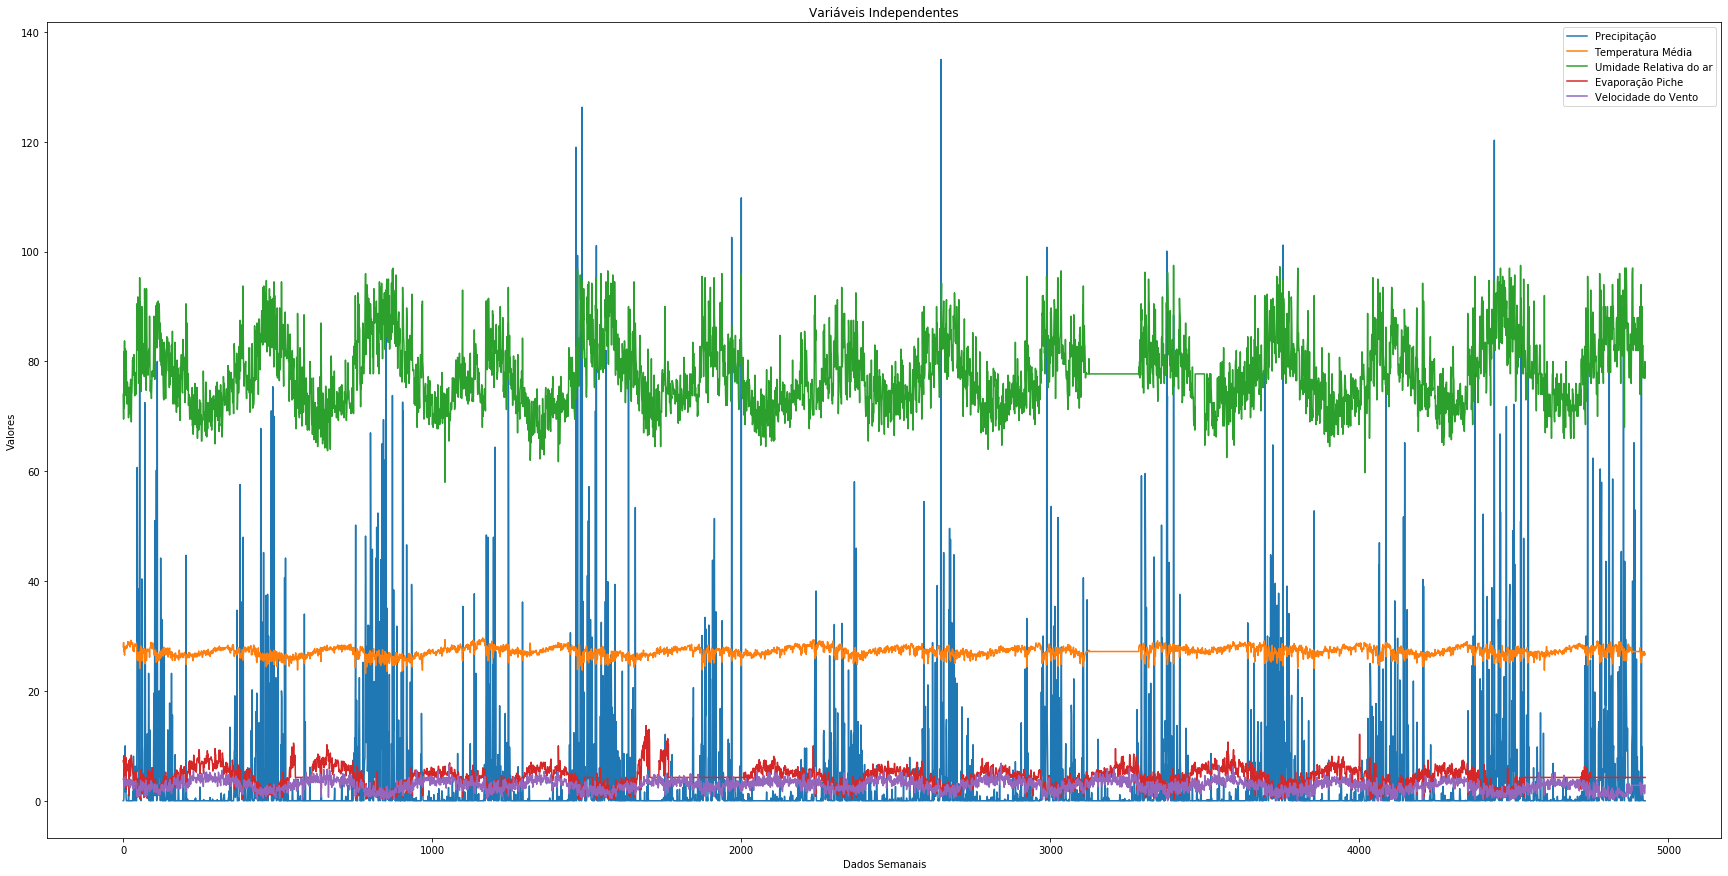

In [7]:

plt.figure(figsize=(30,15))
data.Precipitacao.plot(label="Precipitação")
data.TempMedia.plot( label="Temperatura Média")
data.Umidade.plot( label="Umidade Relativa do ar")
data.Evaporacao.plot( label="Evaporação Piche")
data.VelVento.plot( label="Velocidade do Vento")
plt.title("Variáveis Independentes")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

### Verificar dados faltando de Infectados

In [8]:
tot_nulos=data2.isnull().sum()
tot_nulos

Data          0
Infectados    0
Semana        0
Ano           0
dtype: int64

In [9]:
data2

,Data,Infectados,Semana,Ano
0,01/01/2007,6,1,2007
1,02/01/2007,10,1,2007
2,03/01/2007,26,1,2007
3,04/01/2007,20,1,2007
4,05/01/2007,22,1,2007
...,...,...,...,...
4921,22/06/2020,4,26,2020
4922,23/06/2020,4,26,2020
4923,24/06/2020,0,26,2020
4924,25/06/2020,0,26,2020


### Transforma dados de Infectados de Diário para Semanal

In [10]:
data2Semana = data2.groupby(by=['Ano','Semana'], as_index=False).sum()
for col_name in data2Semana:
    print(col_name)


Ano
Semana
Infectados


### Plota Dados de Infectados

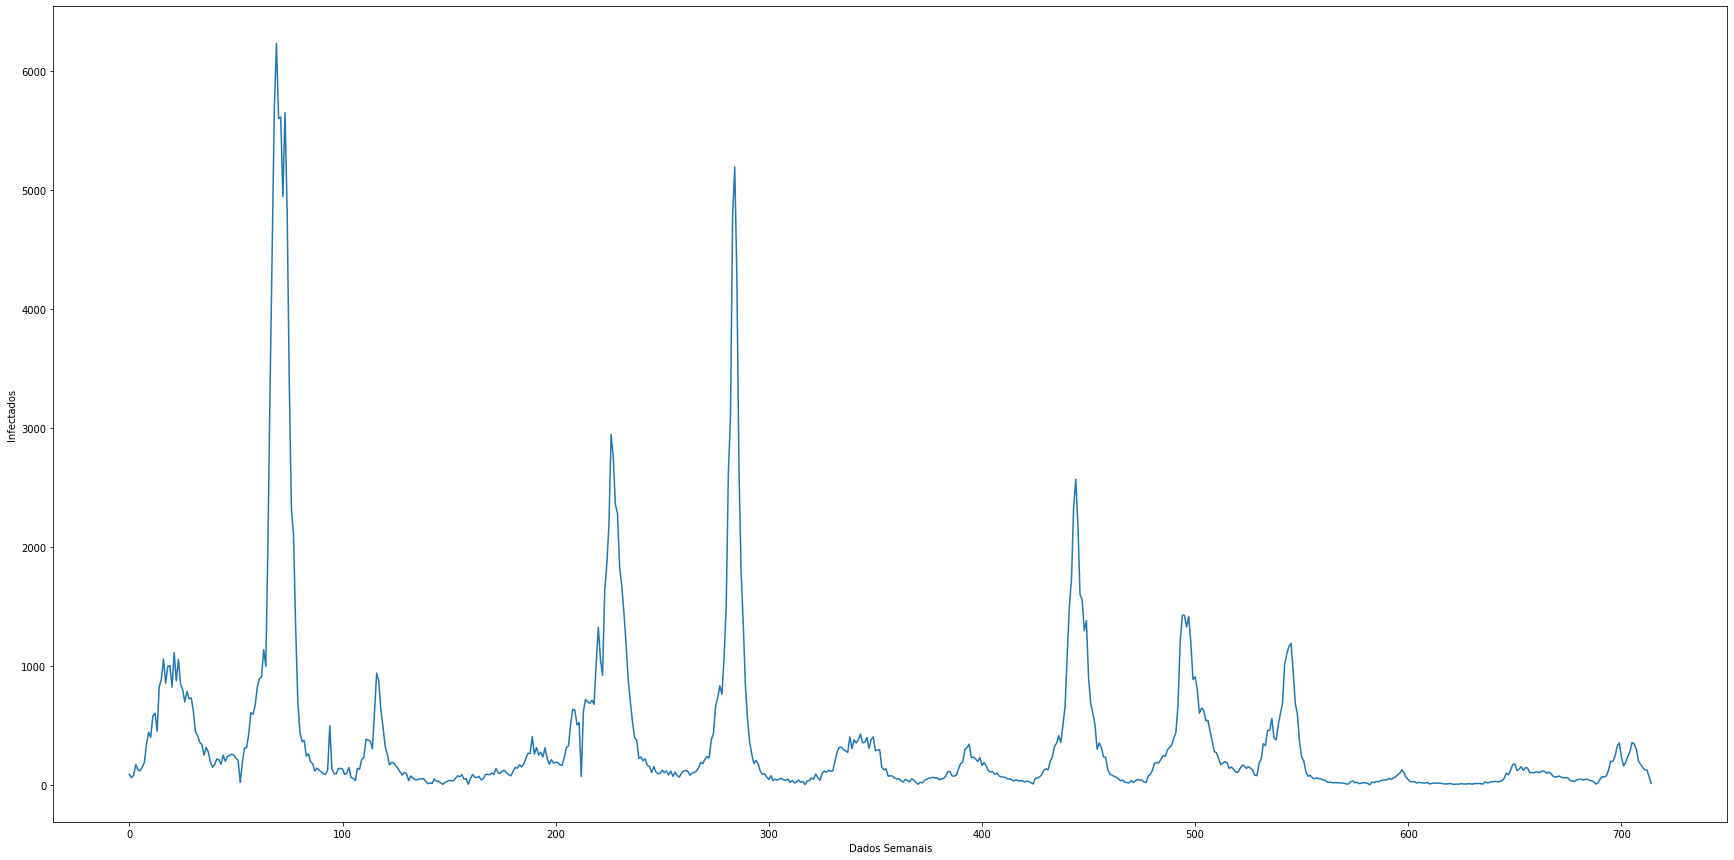

In [11]:
plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

### Seleciona dados com Picos de Dengue

In [12]:
dataSemana=dataSemana.iloc[0:580]
data2Semana=data2Semana.iloc[:580]

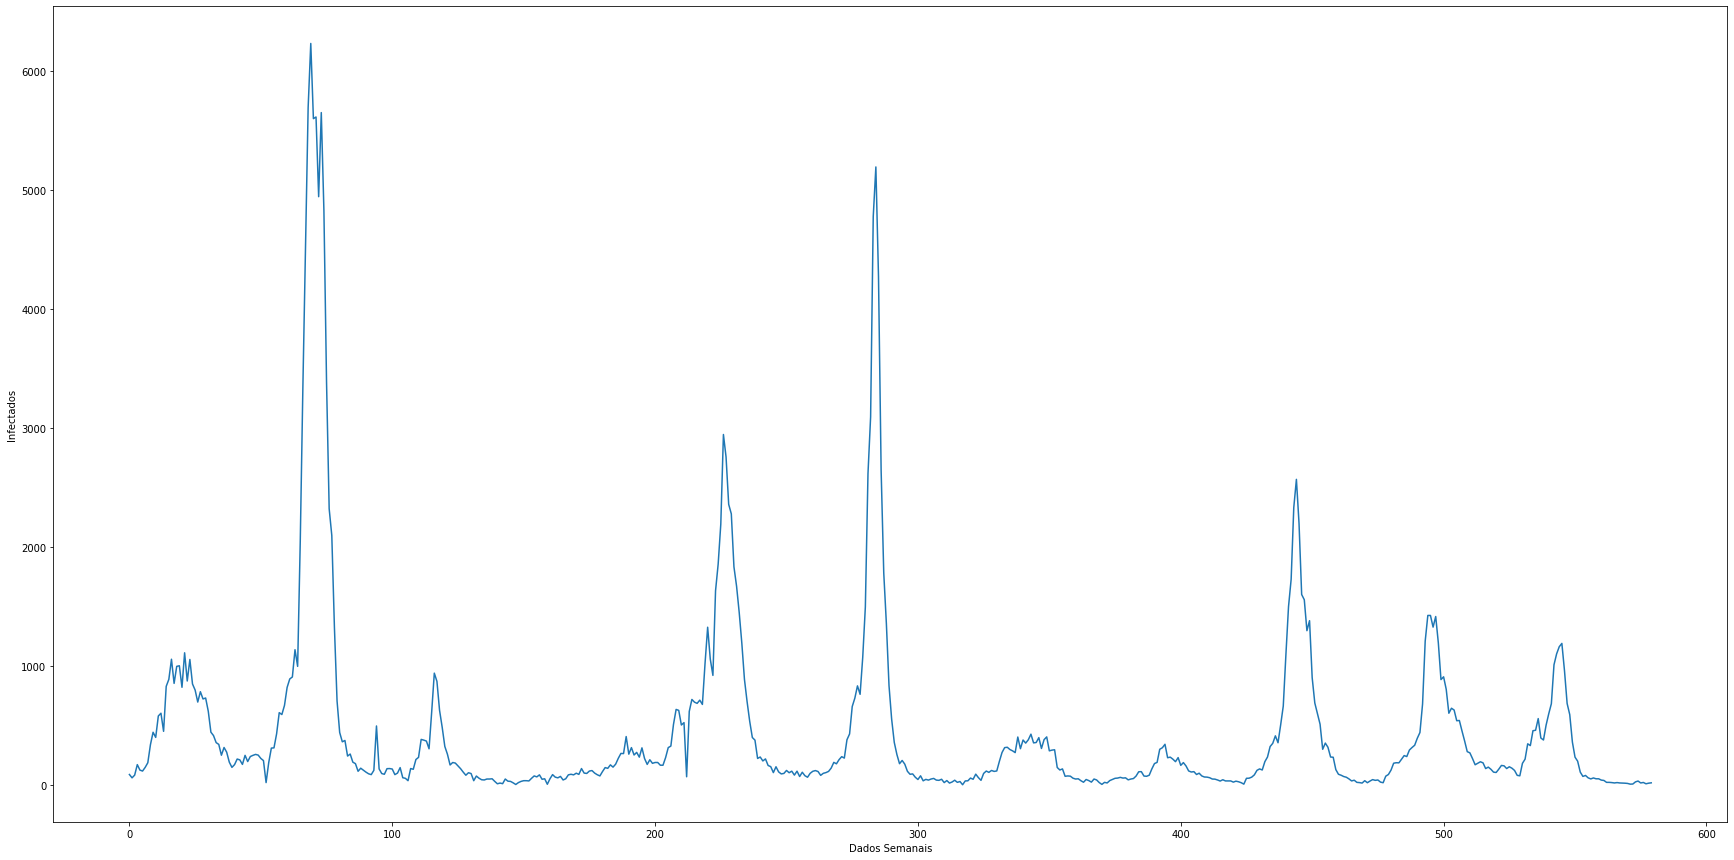

In [13]:
plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

## Divide os dados em Dados de Treino e Teste

In [14]:
X_train=dataSemana.iloc[:380]
X_test=dataSemana.iloc[381:]
y_train = data2Semana.iloc[:380]
submission = data2Semana.iloc[381:]

X_train,X_test

(      Ano  Semana  Precipitacao  TempMaxima  TempMinima  Insolacao  \
 0    2007       1          17.9       183.6       155.2       45.5   
 1    2007       2          18.2       220.9       177.7       58.6   
 2    2007       3           1.2       226.1       184.9       59.3   
 3    2007       4           0.0       225.2       183.9       62.2   
 4    2007       5           9.7       223.8       184.6       43.4   
 ..    ...     ...           ...         ...         ...        ...   
 375  2014       5          28.2       222.4       167.8       57.1   
 376  2014       6          74.4       216.8       161.6       48.6   
 377  2014       7          26.9       216.9       168.4       47.2   
 378  2014       8          42.9       212.8       161.4       32.8   
 379  2014       9           0.0       222.3       165.9       66.7   
 
      Evaporacao  TempMedia  Umidade   VelVento  
 0          35.0     166.32   454.25  21.605174  
 1          40.1     195.44   541.25  23.46666

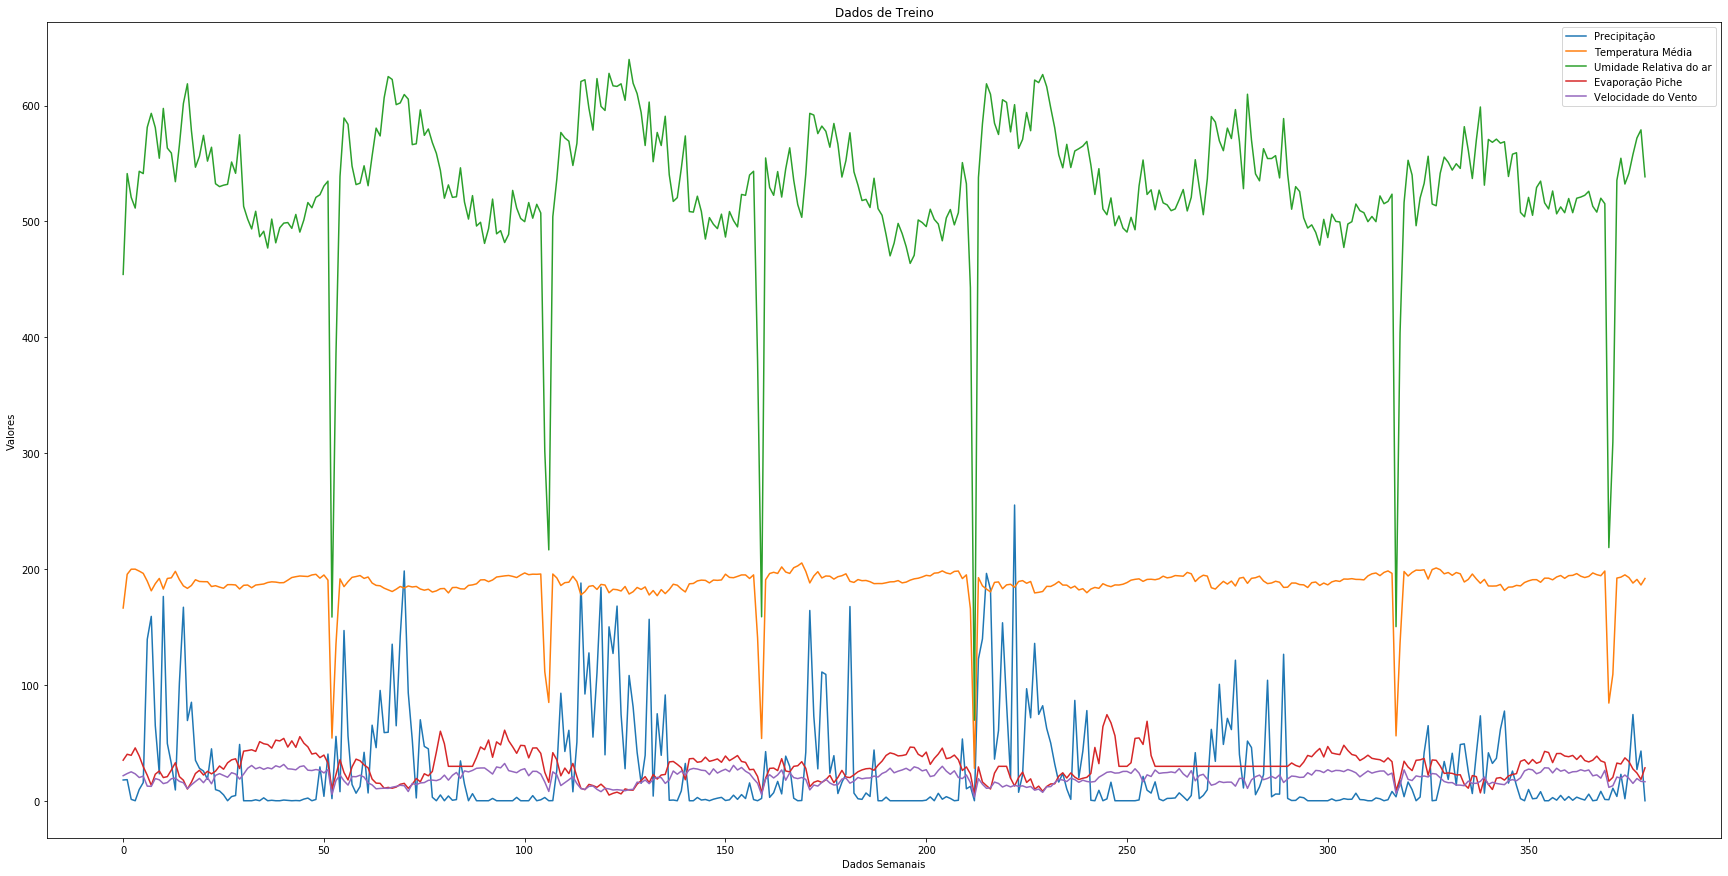

In [15]:
## Dados de Treino
plt.figure(figsize=(30,15))
X_train.Precipitacao.plot(label="Precipitação")
X_train.TempMedia.plot( label="Temperatura Média")
X_train.Umidade.plot( label="Umidade Relativa do ar")
X_train.Evaporacao.plot( label="Evaporação Piche")
X_train.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Treino")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()


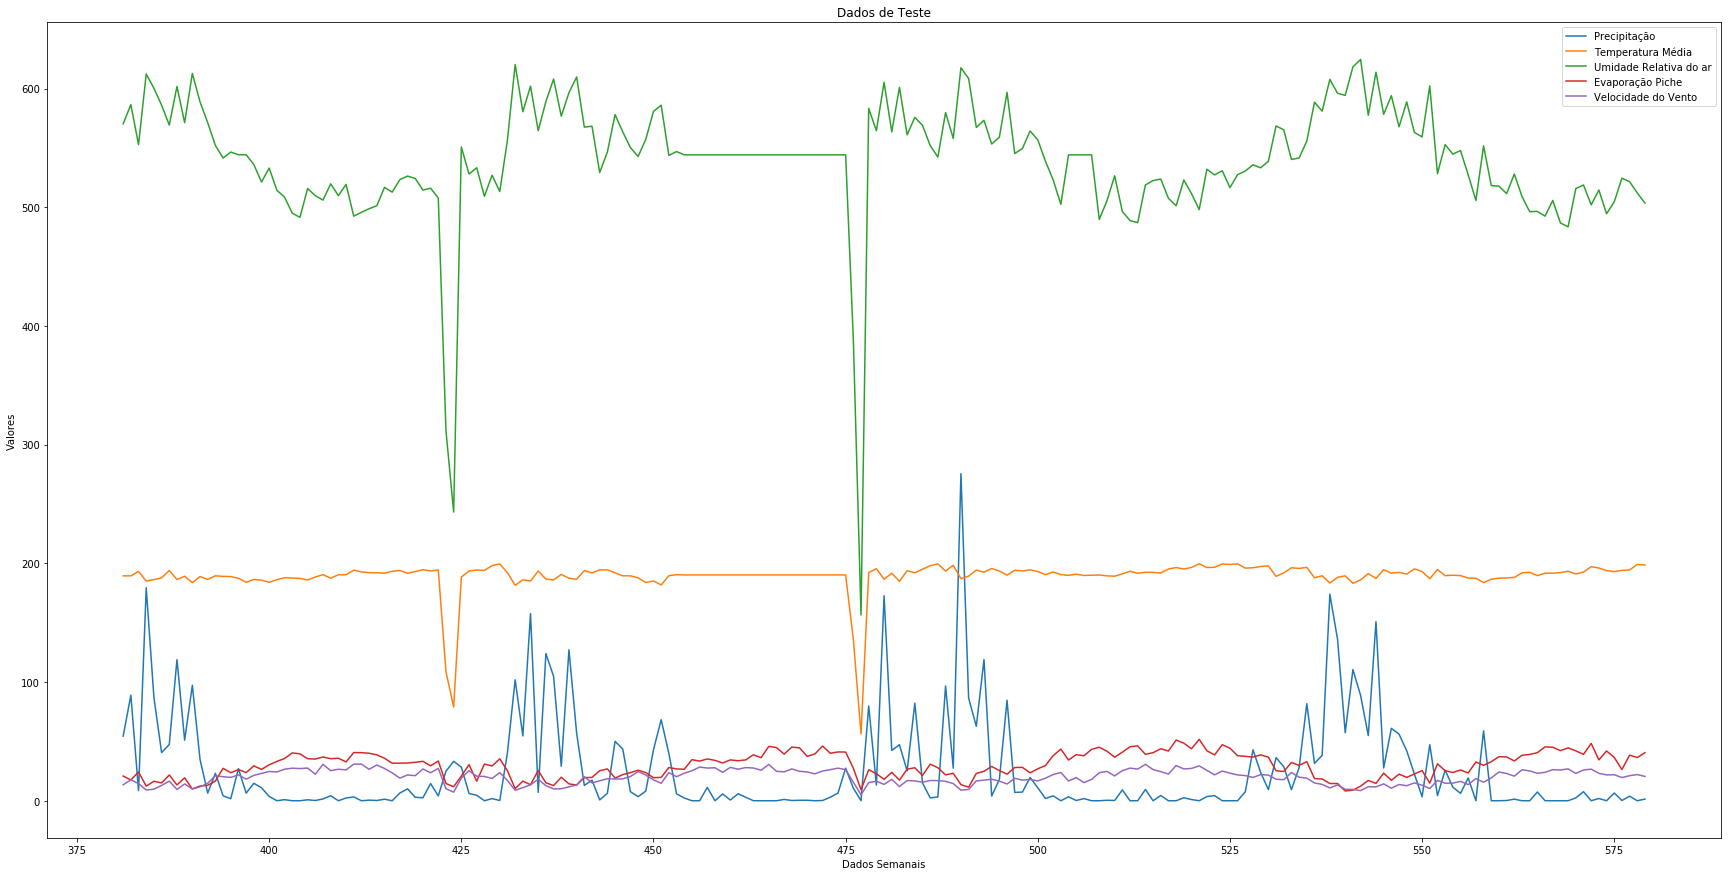

In [16]:
## Dados de Teste
plt.figure(figsize=(30,15))
X_test.Precipitacao.plot(label="Precipitação")
X_test.TempMedia.plot( label="Temperatura Média")
X_test.Umidade.plot( label="Umidade Relativa do ar")
X_test.Evaporacao.plot( label="Evaporação Piche")
X_test.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Teste")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()


### Normalizador estatístico, onde o resultado da normalização garante média zero e variância/desvio parão unitária.

In [17]:
normalizador = StandardScaler()

X_train.iloc[:,2:] = normalizador.fit_transform(X_train.iloc[:,2:])
X_test.iloc[:,2:] = normalizador.transform(X_test.iloc[:,2:])
X_train,X_test,

(      Ano  Semana  Precipitacao  TempMaxima  TempMinima  Insolacao  \
 0    2007       1     -0.243068   -1.478775   -0.547111  -0.561694   
 1    2007       2     -0.236339    0.246909    0.784234   0.276746   
 2    2007       3     -0.617682    0.487487    1.210264   0.321548   
 3    2007       4     -0.644601    0.445848    1.151093   0.507157   
 4    2007       5     -0.427010    0.381077    1.192513  -0.696101   
 ..    ...     ...           ...         ...         ...        ...   
 375  2014       5     -0.012019    0.316306    0.198442   0.180741   
 376  2014       6      1.024339    0.057222   -0.168417  -0.363285   
 377  2014       7     -0.041180    0.061849    0.233944  -0.452889   
 378  2014       8      0.317731   -0.127837   -0.180252  -1.374533   
 379  2014       9     -0.644601    0.311680    0.086017   0.795171   
 
      Evaporacao  TempMedia   Umidade  VelVento  
 0      0.422074  -1.092734 -1.197580  0.262751  
 1      0.853656   0.473208  0.159881  0.58643

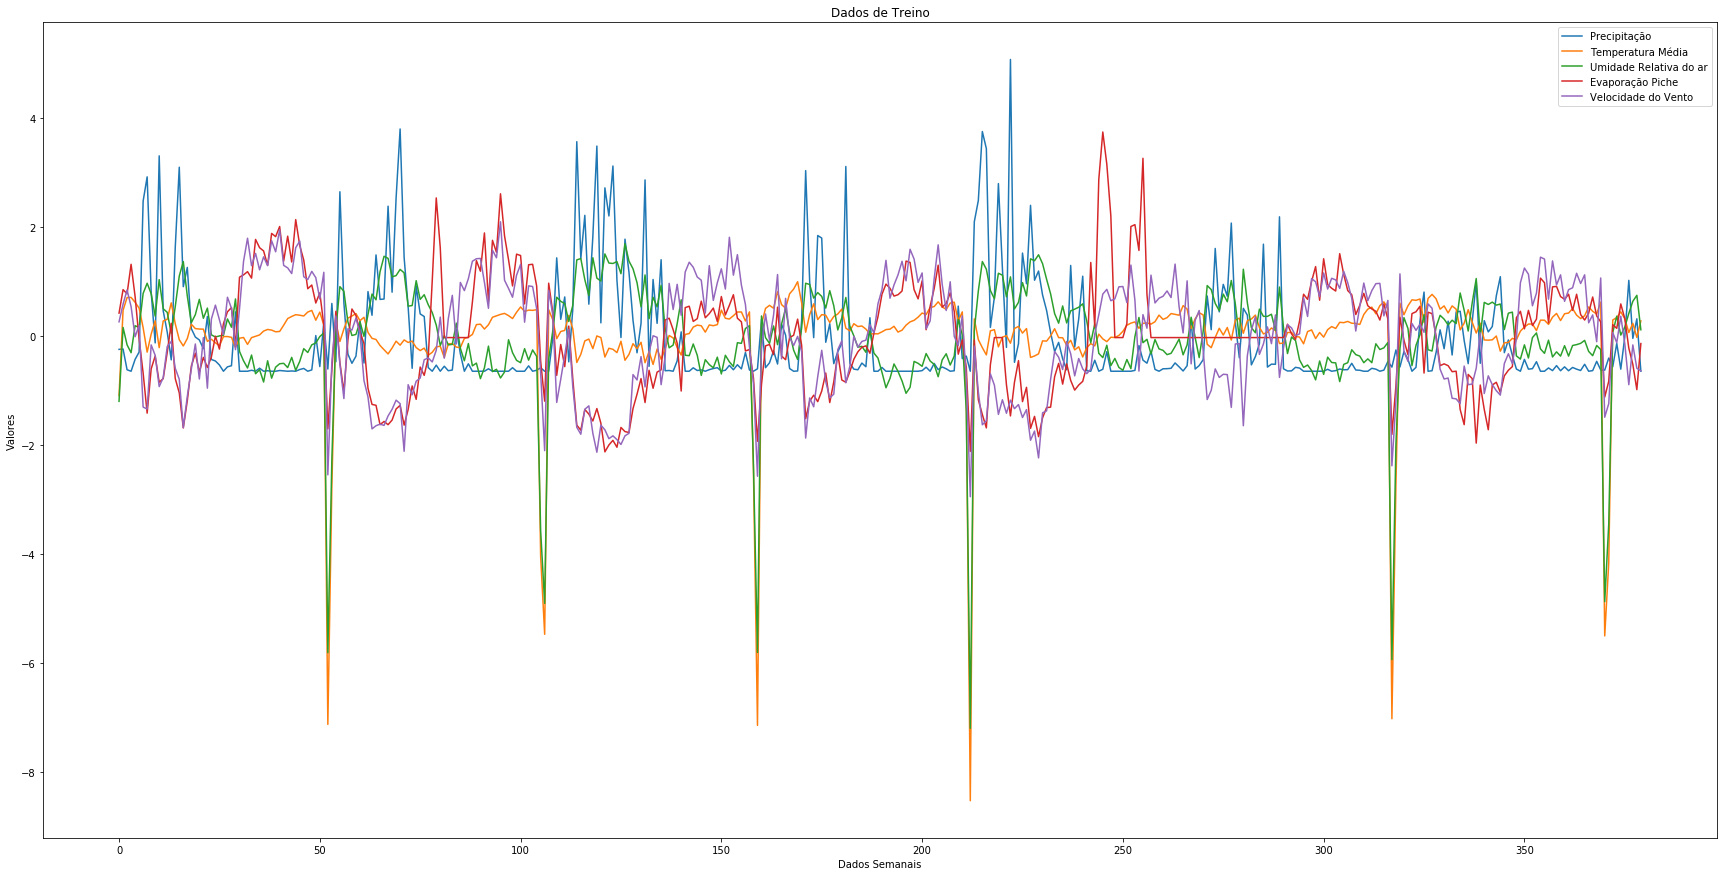

In [18]:
## Dados de Treino Normalizados
plt.figure(figsize=(30,15))
X_train.Precipitacao.plot(label="Precipitação")
X_train.TempMedia.plot( label="Temperatura Média")
X_train.Umidade.plot( label="Umidade Relativa do ar")
X_train.Evaporacao.plot( label="Evaporação Piche")
X_train.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Treino")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

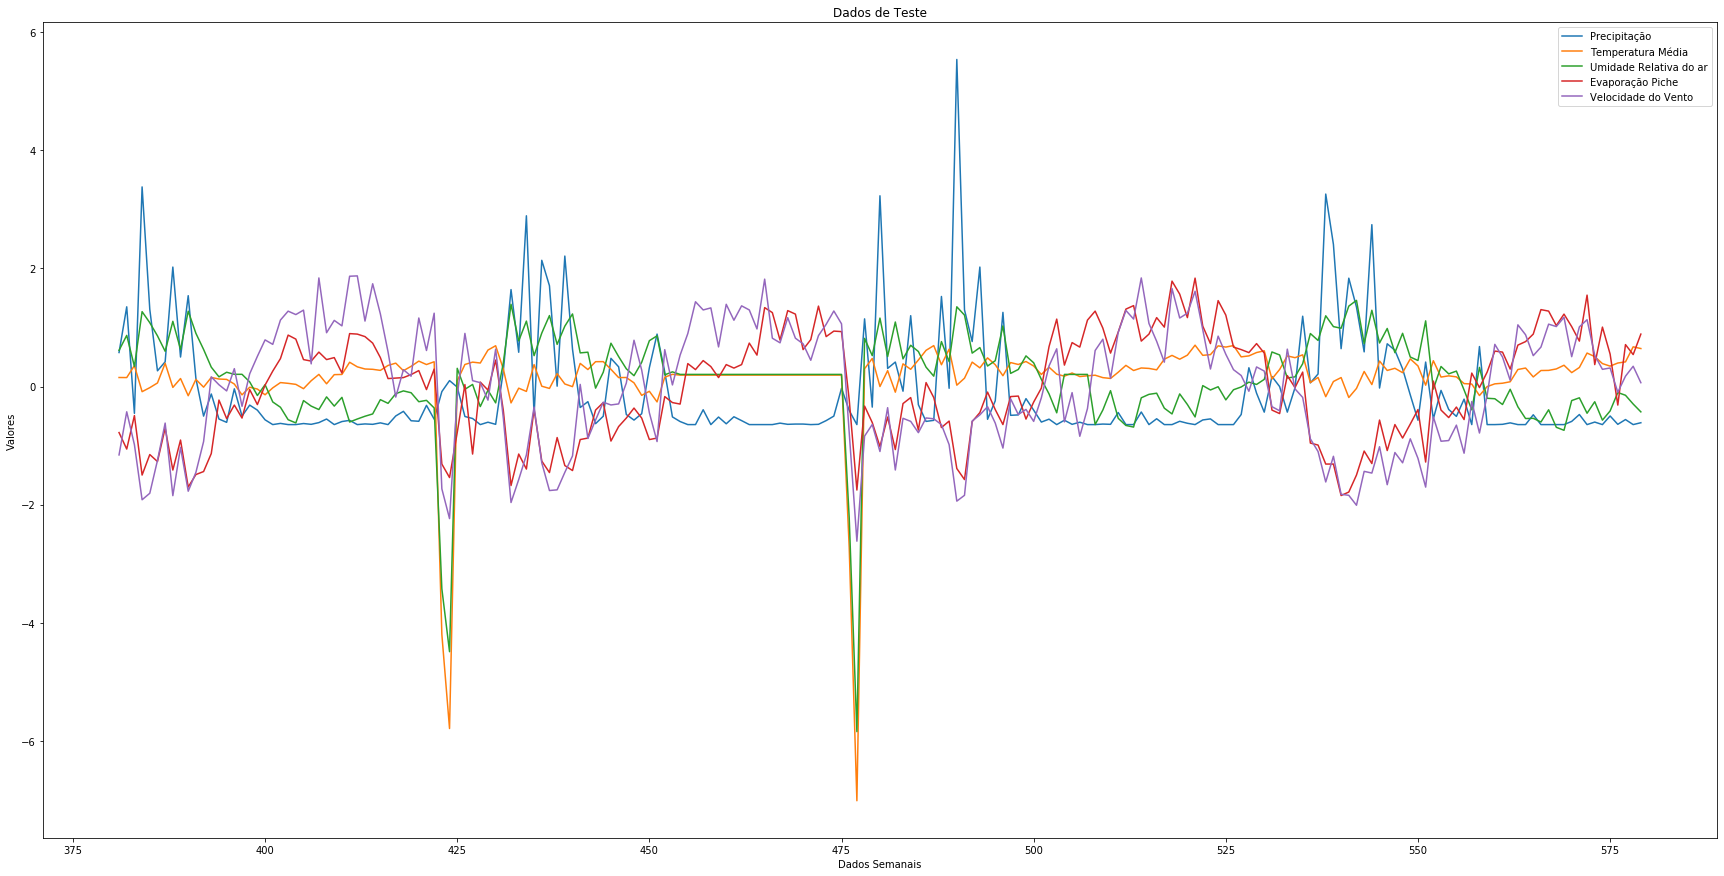

In [19]:
## Dados de Teste Normalizados
plt.figure(figsize=(30,15))
X_test.Precipitacao.plot(label="Precipitação")
X_test.TempMedia.plot( label="Temperatura Média")
X_test.Umidade.plot( label="Umidade Relativa do ar")
X_test.Evaporacao.plot( label="Evaporação Piche")
X_test.VelVento.plot( label="Velocidade do Vento")
plt.title("Dados de Teste")
plt.legend()
plt.xlabel('Dados Semanais')
plt.ylabel('Valores')

plt.show()

Nossa variável de destino, "Infectados" é um número inteiro não negativo, o que significa que estamos procurando fazer algumas previsões de contagem. As técnicas de regressão padrão para esse tipo de previsão incluem:
Regressão de Poisson
Regressão binomial negativa.

Qual técnica terá melhor desempenho depende de muitas coisas, mas a escolha entre a regressão de Poisson e a regressão binomial negativa é bastante direta.

A regressão de Poisson se ajusta de acordo com a suposição de que a média e a variância da distribuição da população são iguais. Quando não são, especificamente quando a variação é muito maior que a média, a abordagem binomial negativa é melhor.

A regressão binomial negativa simplesmente levanta a suposição de que a média e variância da população são iguais, permitindo uma classe maior de modelos possíveis. De fato, dessa perspectiva, a distribuição de Poisson é apenas um caso especial da distribuição binomial negativa.

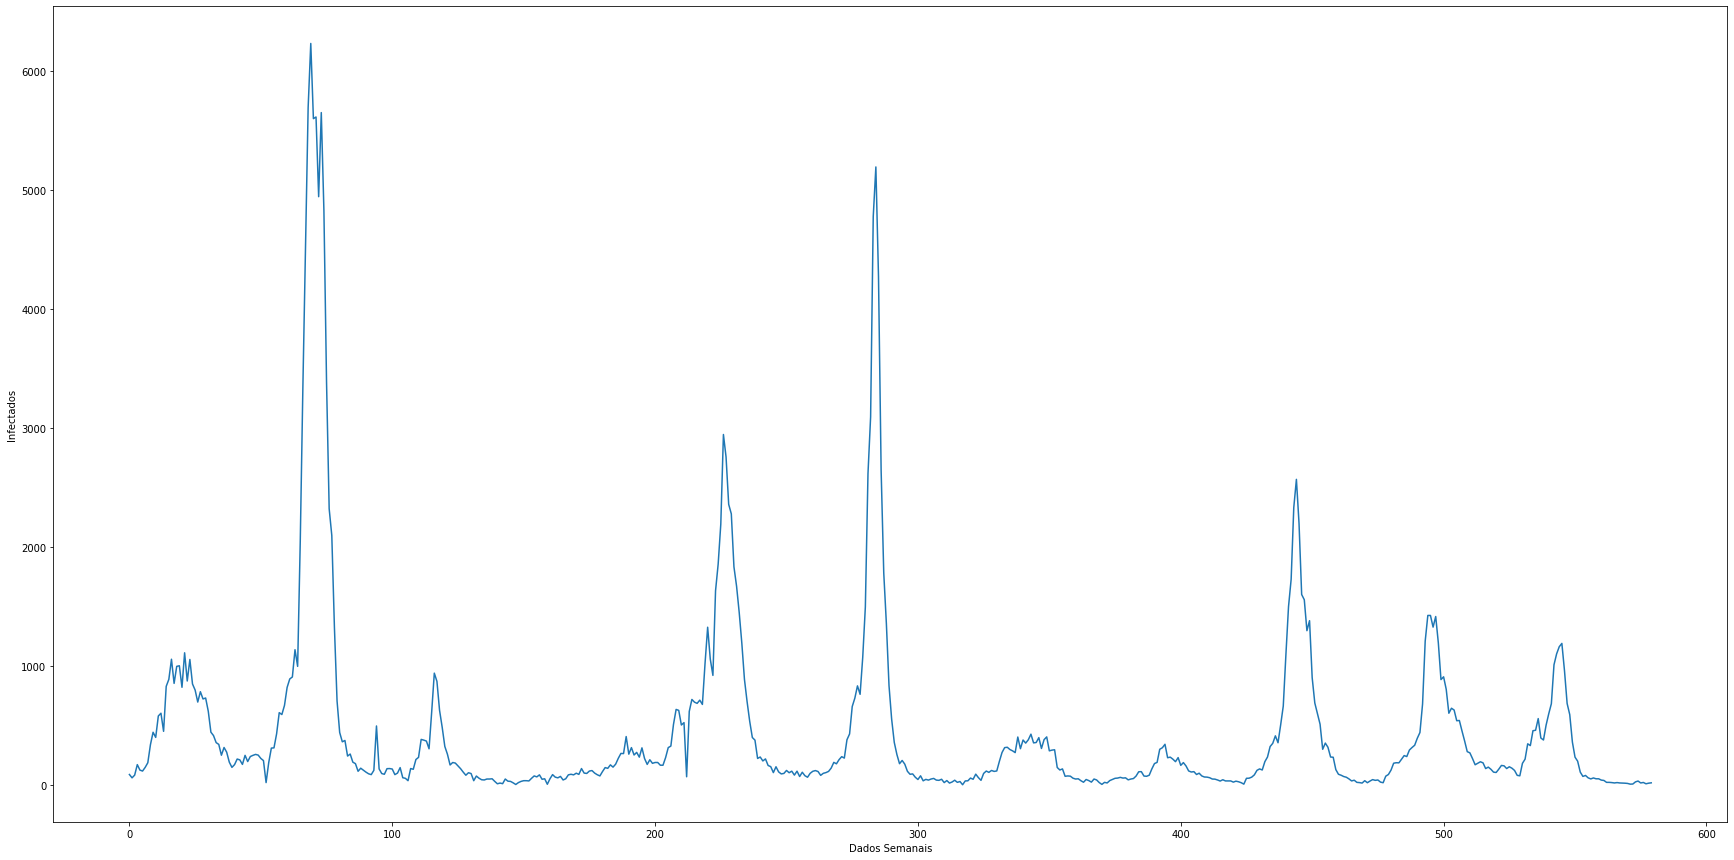

In [20]:
# Dados de "Infectados" de treino
plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(data2Semana['Infectados'])
plt.show()

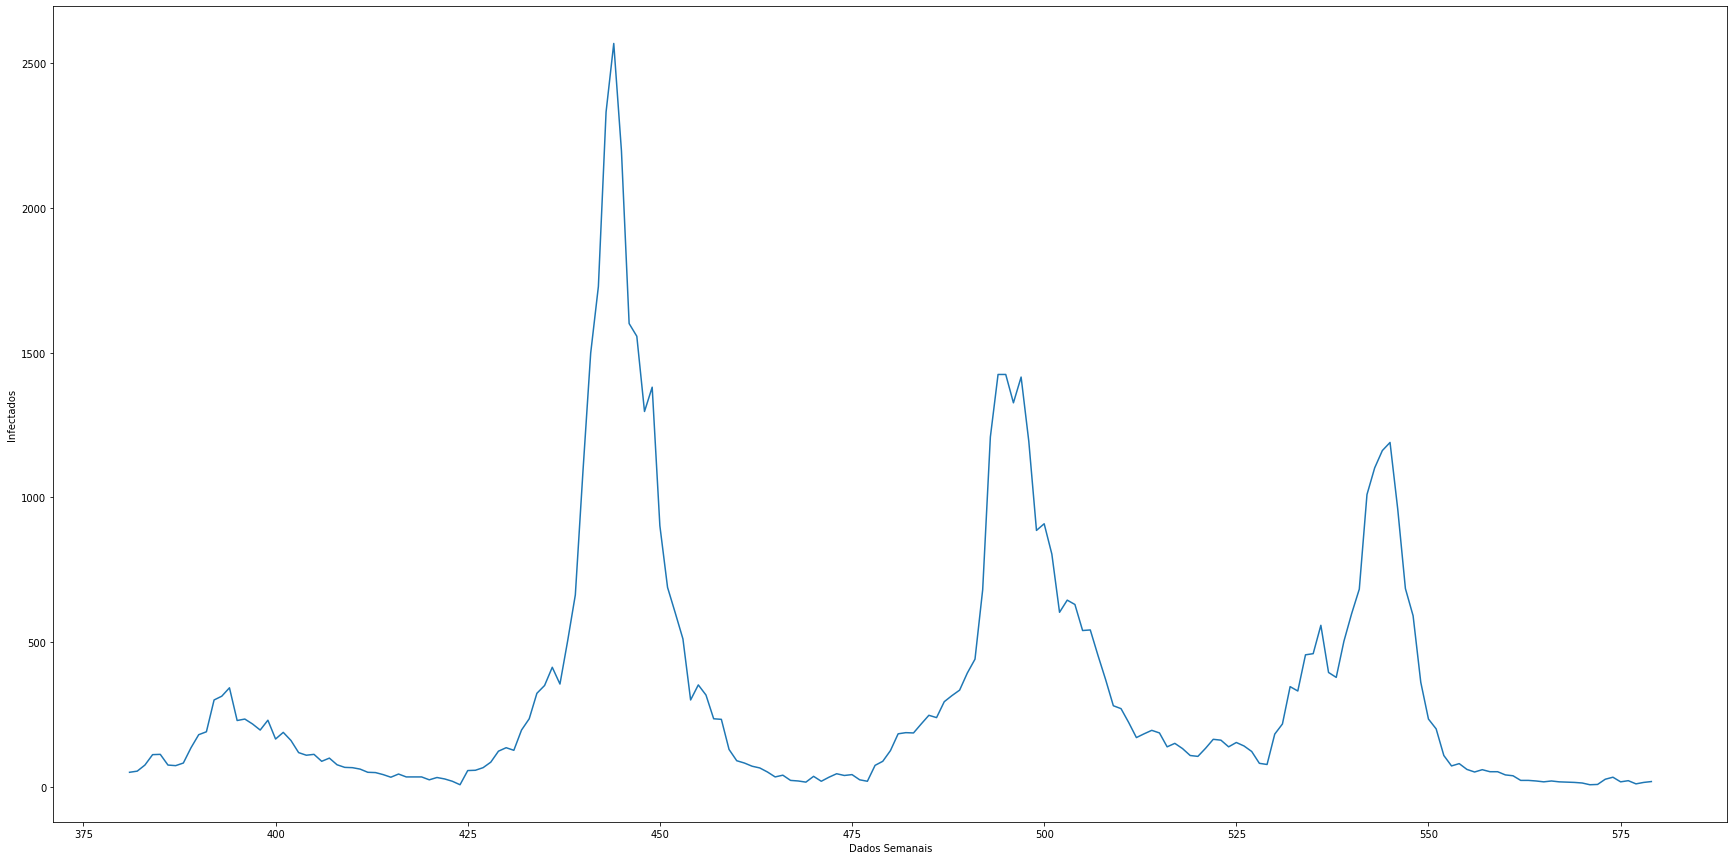

In [21]:
# Dados de "Infectados" de Treino
plt.figure(figsize=(30,15))
plt.xlabel('Dados Semanais')
plt.ylabel('Infectados')
plt.plot(submission['Infectados'])
plt.show()

In [22]:
print('Media e Variancia dos Infectados')
print('mean: ', y_train.mean()[2])
print('std :', y_train.std()[2])
print('var :', y_train.var()[2])

Media e Variancia dos Infectados
mean:  519.9342105263158
std : 981.3999657417709
var : 963145.8927579491


## Variancia maior que media sugere que a variável "Infectados" pode ser descrita por uma distribuição binomial negativa; portanto, usaremos uma regressão binomial negativa abaixo. 

## Mostra Correlação entre os atributos


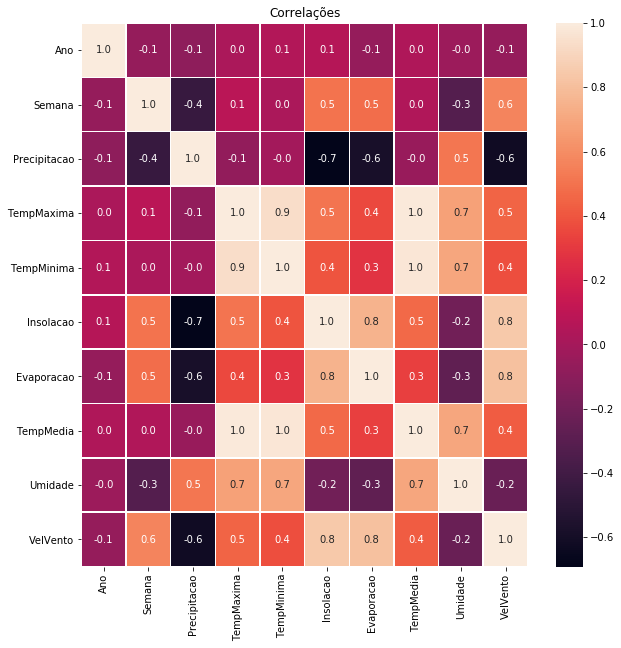

In [23]:
f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()


### Verifica-se que TempMaxima e TemMinima estão fortemente relacionada com TempMedia, sugerindo que podemos excluir estes 2  atributos.

In [24]:
delete = ['TempMinima','TempMaxima']
for z in delete:
    del X_train[z]
    del X_test[z]

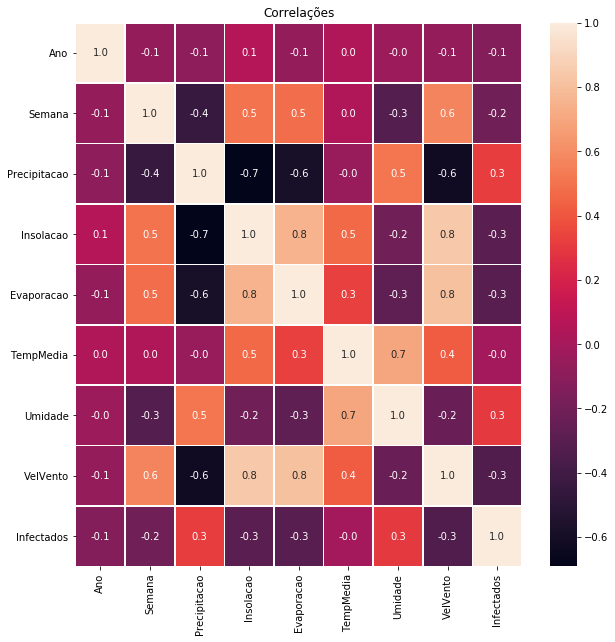

In [25]:
X_train['Infectados'] = y_train['Infectados']

f,ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
ax.set_title('Correlações')
plt.show()

### Correlação dos atributos com os Casos de Infectados por Dengue

Text(0.5, 1.0, 'Correlações')

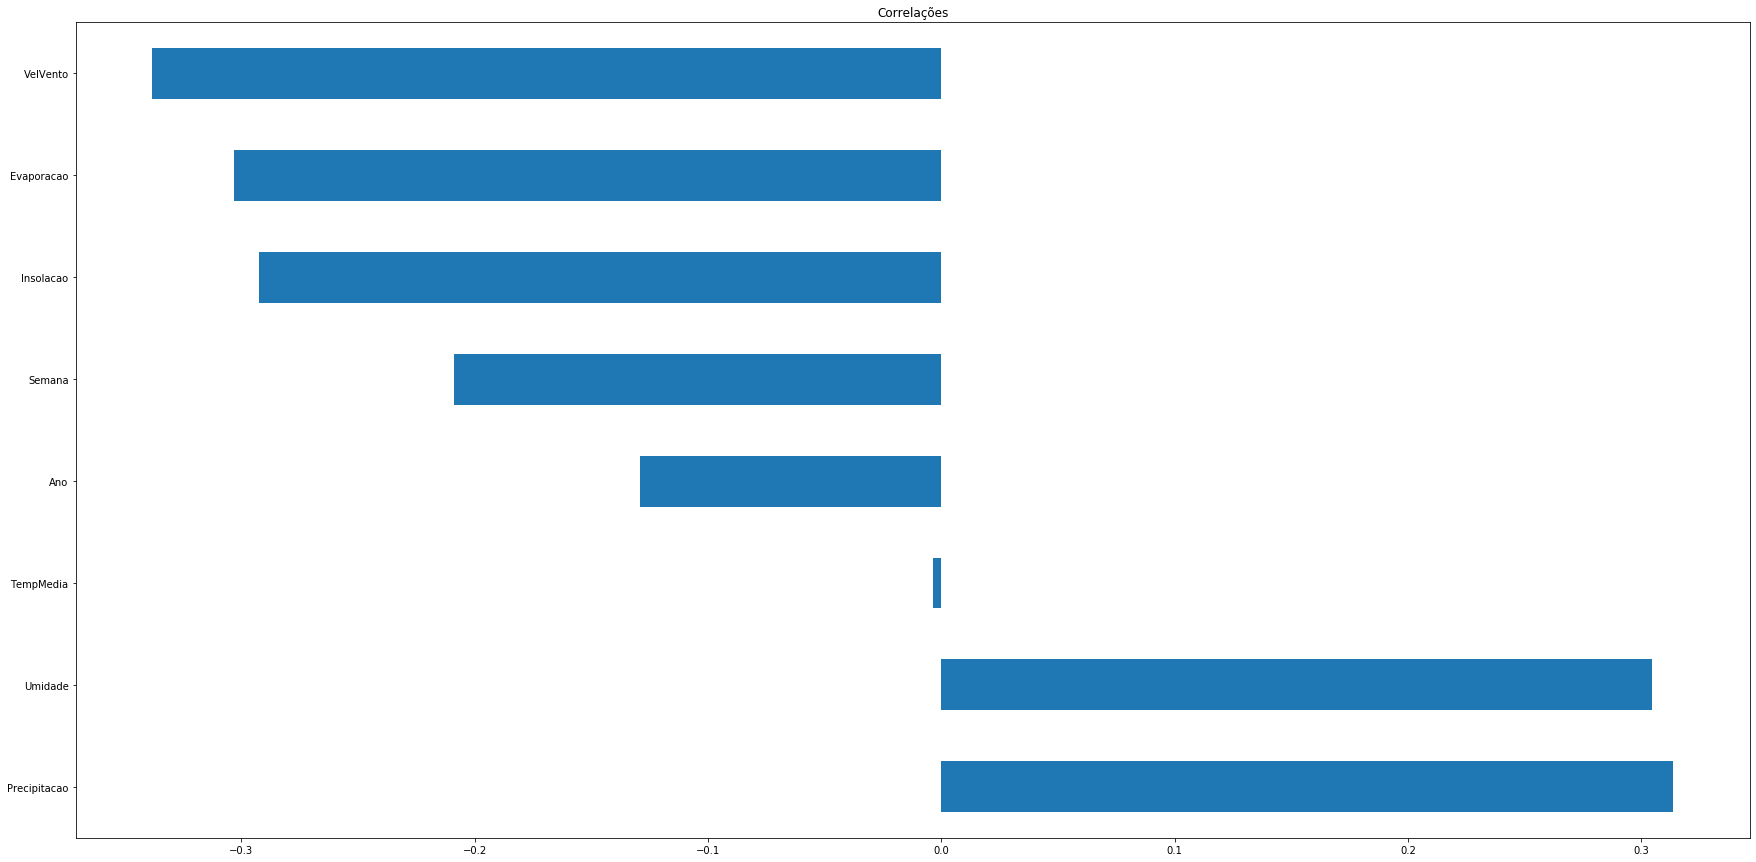

In [26]:
plt.figure(figsize=(30,15))
correlations = X_train.corr()
(correlations['Infectados'].drop('Infectados').sort_values(ascending=False).plot.barh())
plt.title('Correlações')

### Verifica-se uma baixa correlação da Temperatura Média com os casos de Infectados, talvez, devido à pequena variação de temperatura que ocorre no Ceará

### Plota o número de infectados para cada ano

Text(0, 0.5, 'Total de Infectados')

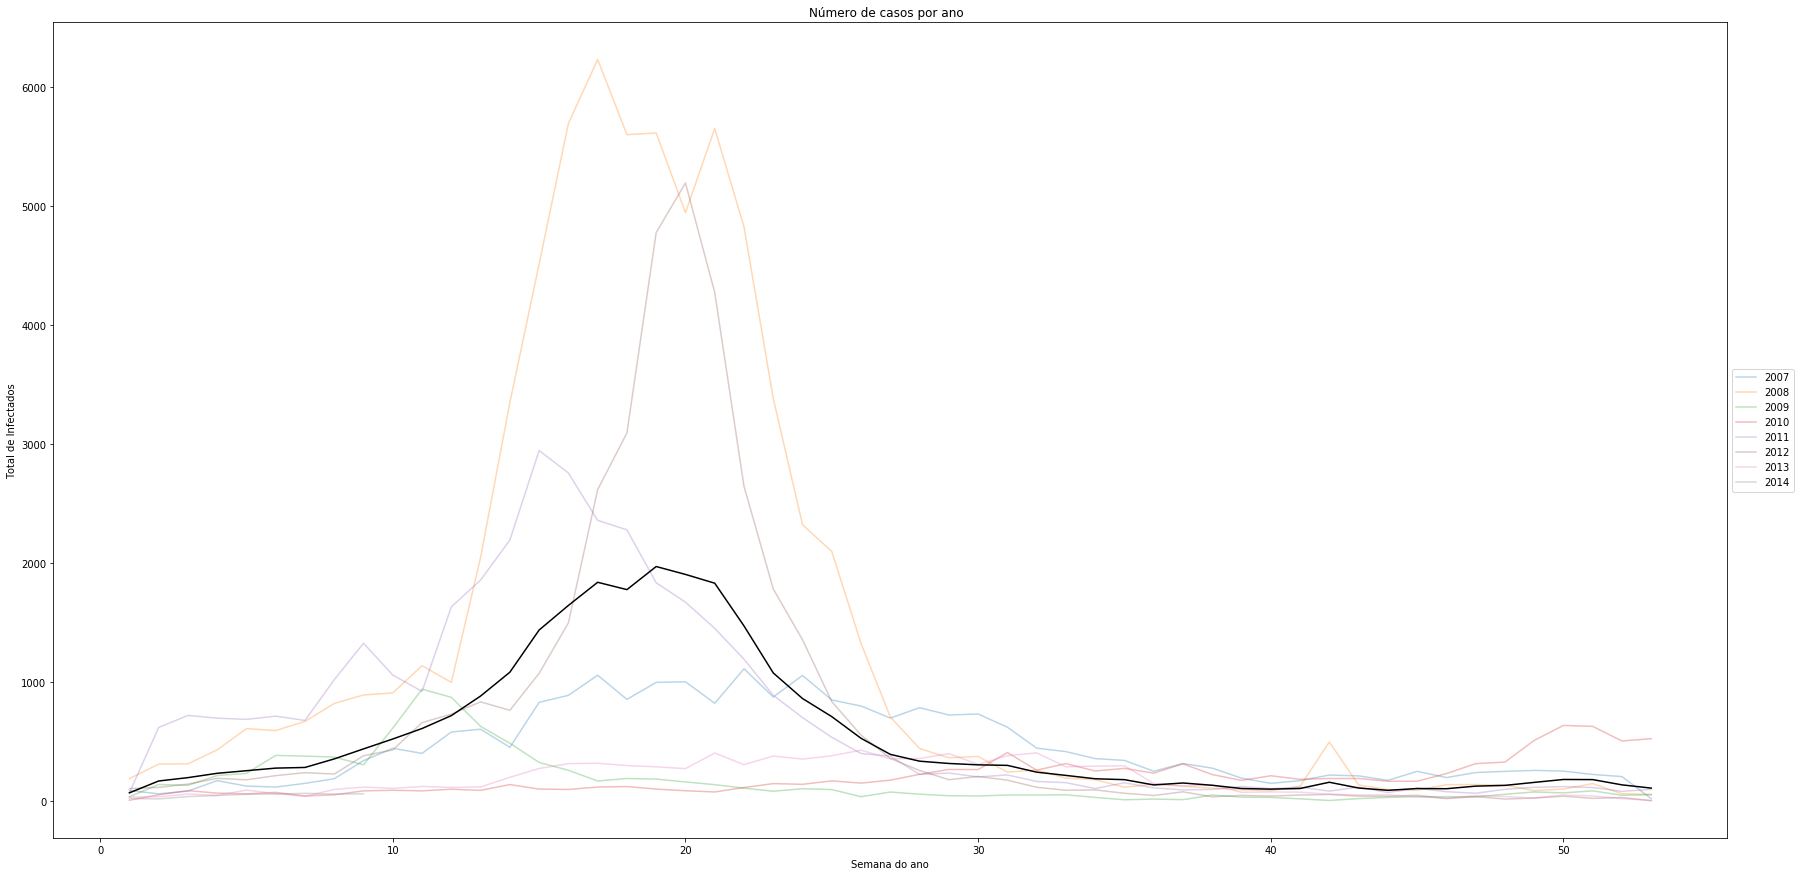

In [27]:
#Numero de Casos por semana
for i in set(y_train['Ano']):
    df = y_train[y_train['Ano'] == i]
    df.set_index('Semana', drop = True, inplace = True)
    plt.plot(df['Infectados'], alpha = .3)
    
y_train.groupby('Semana')['Infectados'].mean().plot(c = 'k', figsize = (30,15))
plt.legend(set(y_train['Ano']), loc='center left', bbox_to_anchor=(1, .5))

plt.title('Número de casos por ano  ')
plt.xlabel('Semana do ano')
plt.ylabel('Total de Infectados')

###  Verificas uma incidência maior de dengue no final do primeiro semestre, que coincide com o final do período chuvoso no Ceará

## Construindo modelos de Machine Learning


In [28]:
#features=['Infectados','Precipitacao','Insolacao','Evaporacao','TempMedia','Umidade','VelVento'] 
features=['Precipitacao','Insolacao','Evaporacao','Umidade','VelVento'] 

X_train=X_train.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')
X_test=X_test.join(X_train.groupby(['Semana'])['Infectados'].mean(), on=['Semana'], rsuffix='_avg')

#TRAIN
X= X_train[features]
Y = X_train['Infectados']

#TEST
Xt= X_test[features]
X.fillna(method='bfill', inplace=True)
Xt.fillna(method='bfill', inplace=True)


## Criando os modelos e treinando 

### SVR - Support vetor Regression, um sub-tipo do SVM

In [29]:
# SCR
svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1), cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
t0 = time.time()
svr.fit(X,Y)
svr_fit = time.time() - t0
print("Complexidade SVR e largura de banda selecionadas e modelo ajustado em %.3f s"
      % svr_fit)
model=svr.best_estimator_
print(model)


Complexidade SVR e largura de banda selecionadas e modelo ajustado em 0.798 s
SVR(C=100.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


###   KNN (k-nearest neighbors )

In [30]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 30)
knn.fit(X,Y)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=30, p=2,
                     weights='uniform')

### Separa dados de TREINO (70%)  e teste (30%) Para VALIDAÇÃO

In [31]:
train_subtrain = X_train.sample(frac=0.7)
train_subtest = X_train.loc[~X_train.index.isin(train_subtrain.index)]

train_subtrain.fillna(method='bfill', inplace=True)
train_subtest.fillna(method='bfill', inplace=True)



### Treina e Valida os Modelos

In [32]:
#SVM
preds= model.predict(train_subtest[features]).astype(int)
train_subtest['fitted'] = preds

# KNN
preds2 = knn.predict(train_subtest[features]).astype(int)
train_subtest['fitted2'] = preds2




## Plota o Treino e Validação dos Modelos

Text(0, 0.5, 'Total de Infectados')

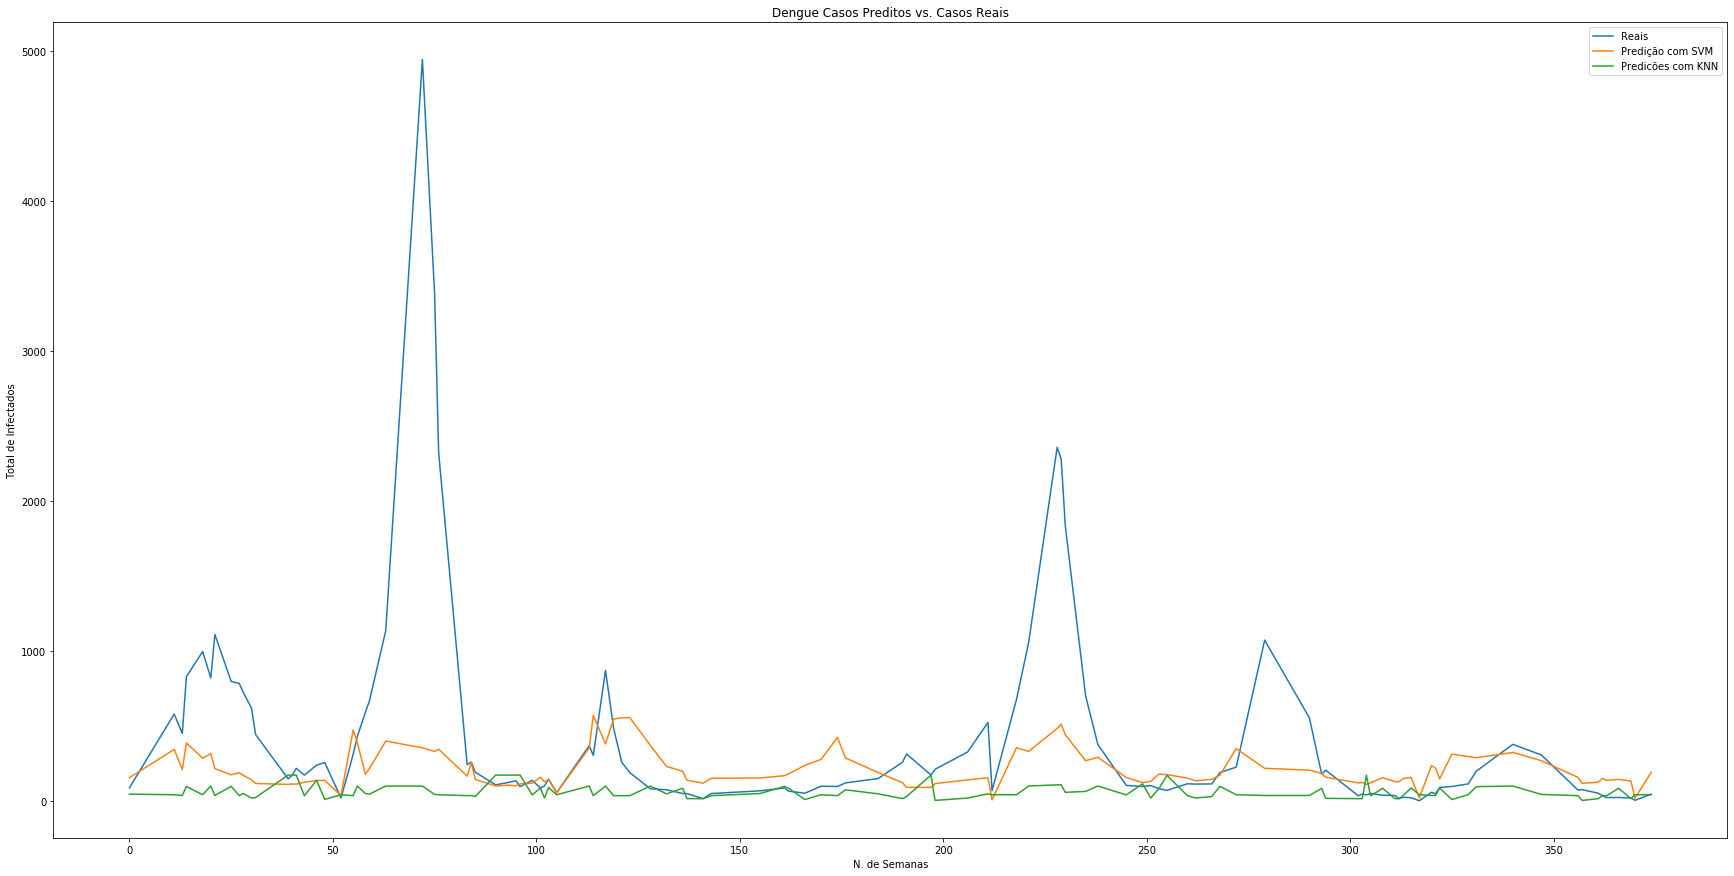

In [33]:
plt.figure(figsize=(30,15))
train_subtest.Infectados.plot(label="Reais")
train_subtest.fitted.plot( label="Predição com SVM")
train_subtest.fitted2.plot( label="Predicões com KNN")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Calcula as métricas  - Cross validation com o score R2

### Scores para SVR

In [34]:
scores = cross_val_score(svr, X,Y, cv=5, scoring = "r2")
print("Scores usando SVR:", scores)
print("Média  usando SVR:", scores.mean())

Scores usando SVR: [-0.36248514  0.07523298  0.07882102 -0.23653684 -0.35379798]
Média  usando SVR: -0.15975319028909582


### Scores para KNN

In [35]:
scores = cross_val_score(knn, X,Y, cv=5, scoring = "r2")
print("Scores usando KNN:", scores)
print("Média  usando KNN:", scores.mean())

Scores usando KNN: [-0.24007339 -0.21599016 -0.2115065  -0.23177592 -0.22032994]
Média  usando KNN: -0.22393518131747778


## Faz predição com dados de Teste

In [36]:
#SVM
dataSemana['Infectados']=data2Semana['Infectados']
newPreds= model.predict(dataSemana[features])
dataSemana['fitted'] = newPreds

# KNN
newPreds2 = knn.predict(dataSemana[features])
dataSemana['fitted2'] = newPreds2


Text(0, 0.5, 'Total de Infectados')

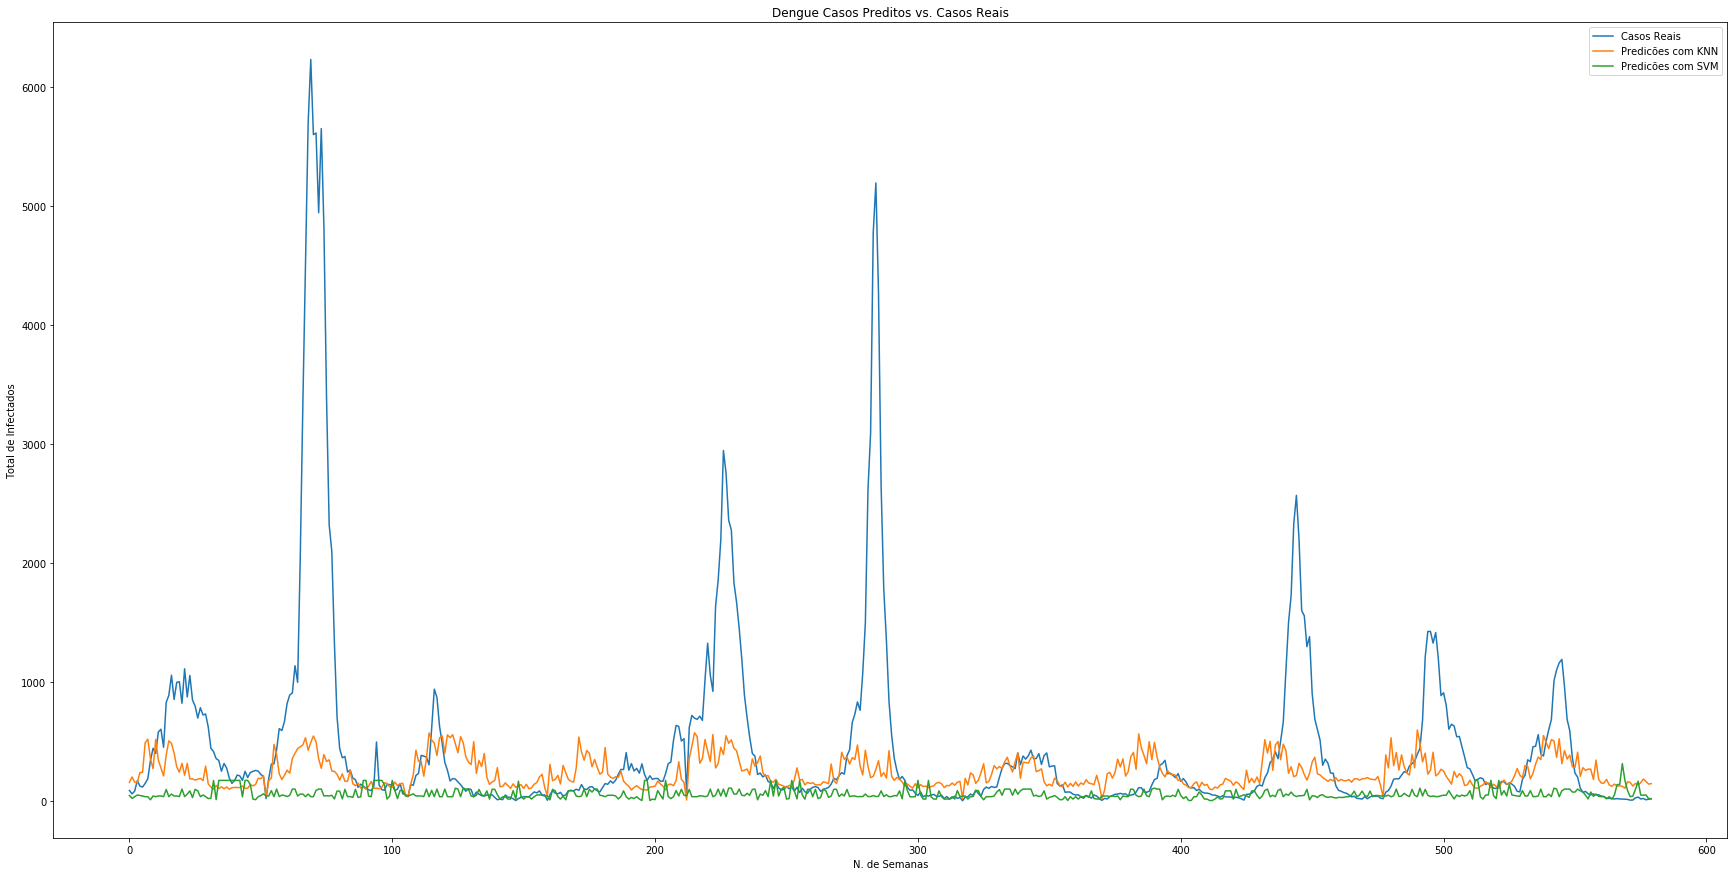

In [37]:

plt.figure(figsize=(30,15))
data2Semana['Infectados'].plot( label="Casos Reais")
dataSemana['fitted'].plot(label="Predicões com KNN")
dataSemana['fitted2'].plot(label="Predicões com SVM")

plt.title("Dengue Casos Preditos vs. Casos Reais")
plt.legend()
plt.xlabel('N. de Semanas')
plt.ylabel('Total de Infectados')

## Conclusão
### Podemos afirmar que os modelos baseados em SVM KNN funcionam bem para previsão de casos dengue em Fortaleza, com uma precisão maior para o modelo baseado no KNN